In [890]:
%matplotlib inline
import matplotlib.pyplot as pl
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

# A few useful constants
KEPLER_BEGIN_BK, KEPLER_END_BK = 130, 1582

In [891]:
transits = pd.read_hdf('observed-long-period-transits.h5', key='transits')
transits = transits[transits.tce_max_mult_ev < 20]
thresholds = pd.read_hdf('transit-rate-by-skygroup-with-threshold.h5', key='rate')

In [892]:
transits['transit_day'] = np.floor(transits.transit_time_x).astype('int')
transits['transit_day_half'] = 0.5 * np.floor(transits.transit_time_x * 2)
transits['transit_day_double'] = (2 * np.floor(transits.transit_time_x * 0.5)).astype('int')
transits.head()

,kepid_x,tce,tce_max_mult_ev,tce_period,tce_plnt_num,transit_time_x,quarter,season,channel,idx,kepid_y,module,output,skygroup,transit_time_y,transit_day,transit_day_half,transit_day_double
0,2304168,002304168-02,12.22,431.719,2,219.298,2,0,4,0,2304168,2,4,84,219.298,219,219.0,218
1,2304168,002304168-02,12.22,431.719,2,651.017,7,1,56,1,2304168,16,4,84,651.017,651,651.0,650
2,2304168,002304168-02,12.22,431.719,2,1082.736,11,1,56,2,2304168,16,4,84,1082.736,1082,1082.5,1082
3,2304168,002304168-02,12.22,431.719,2,1514.455,16,2,84,3,2304168,24,4,84,1514.455,1514,1514.0,1514
4,2303102,002303102-10,11.51,480.481,10,161.570,1,3,32,4,2303102,10,4,84,161.570,161,161.5,160


In [939]:
BIN_BY = 'transit_day_double'
transit_rate_groupby = transits.groupby([BIN_BY, 'skygroup', 'season'])
transit_rate = pd.DataFrame(transit_rate_groupby.size(), columns=['transit_rate_observed'])
transit_rate['channel'] = transit_rate_groupby.first().channel
transit_rate['quarter'] = transit_rate_groupby.first().quarter
assert((transit_rate_groupby.first().channel == transit_rate_groupby.mean().channel).all())
assert((transit_rate_groupby.first().quarter == transit_rate_groupby.mean().quarter).all())

In [940]:
threshold_col = []
for day, skygroup, season in transit_rate.index:
    threshold_col.append(thresholds.ix[skygroup, season].transit_rate_threshold)
transit_rate['transit_rate_threshold'] = threshold_col

In [941]:
transit_rate.head()

transit_rate_observed  channel  quarter  \
transit_day_double skygroup season                                            
130                4        3                           1       56        1   
                   25       3                           1       17        1   
                   37       3                           1       61        1   
                   59       3                           1       67        1   
                   71       3                           1       11        1   

                                    transit_rate_threshold  
transit_day_double skygroup season                          
130                4        3                          4.0  
                   25       3                          4.0  
                   37       3                          5.0  
                   59       3                          5.0  
                   71       3                          4.0

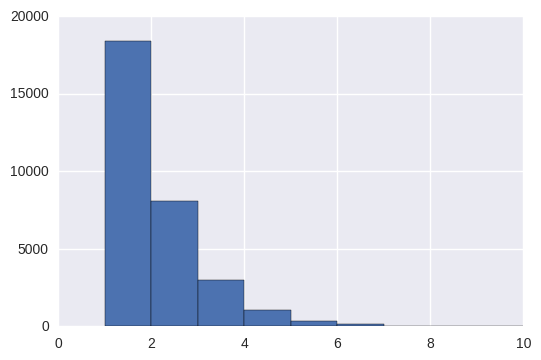

In [942]:
transit_rate.transit_rate_observed.hist(bins=10, range=(0,10))

In [948]:
mask_bad_data = transit_rate.transit_rate_observed >= 2*transit_rate.transit_rate_threshold
mask_bad_data.sum()

111

In [949]:
transit_rate[mask_bad_data]

transit_rate_observed  channel  quarter  \
transit_day_double skygroup season                                            
134                43       3                          11       44        1   
136                43       3                          10       44        1   
138                43       3                          13       44        1   
140                43       3                          11       44        1   
170                42       0                          13       44        2   
172                36       0                           9       52        2   
                   42       0                          11       44        2   
                   58       0                          11       26        2   
184                18       0                          26       66        2   
186                18       0                          18       66        2   
                   58       0                          19       26        2   
                   62       0                           8       22        2   
230                58       0                          26       26        2   
232                26       0                          14       58        2   
                   58       0                         120       26        2   
234                58       0                          44       26        2   
236                58       0                          13       26        2   
238                58       0                          12       26        2   
260                41       1                          13       44        3   
308                66       1                          16       58        3   
402                58       2                          16       58        4   
506                43       3                          17       44        5   
508                43       3                          12       44        5   
510                43       3                          17       44        5   
512                43       3                          21       44        5   
514                43       3                          15       44        5   
518                66       3                          14       26        5   
524                66       3                          12       26        5   
540                58       0                          15       26        6   
                   62       0                           8       22        6   
...                                                   ...      ...      ...   
1240               18       3                          10       58       13   
1254               43       3                          11       44       13   
1256               43       3                          21       44       13   
1258               43       3                          12       44       13   
1260               43       3                          12       44       13   
1262               43       3                          18       44       13   
1264               43       3                          14       44       13   
1274               58       0                          16       26       14   
                   62       0                          12       22       14   
1298               42       0                          10       44       14   
1300               42       0                          10       44       14   
1308               42       0                          11       44       14   
1338               26       0                          12       58       14   
                   58       0                         101       26       14   
1340               26       0                          18       58       14   
                   58       0                          84       26       14   
1342               26       0                          13       58       14   
                   58       0                          55       26       14   
1344   

In [950]:
transit_rate[mask_bad_data].reset_index().groupby('channel').size().sort_values()

channel
51     1
52     1
74     1
66     2
80     2
22     3
58    20
26    29
44    52
dtype: int64

In [951]:
mask_transits_flagged = transits.channel > 999
for transit_day, skygroup, season in transit_rate[mask_bad_data].index:
    mask_transits_flagged |= (
                            (transits[BIN_BY] == transit_day) &
                            (transits.skygroup == skygroup) &
                            (transits.season == season)
                         )
mask_transits_flagged.sum()

2268

In [952]:
tces_to_remove = transits[mask_transits_flagged].tce.unique()
tces_to_remove.size

1054

In [953]:
mask_transits_to_remove = transits.tce.isin(tces_to_remove)
mask_transits_to_remove.sum()

4058

## What is the daily maximum?

In [954]:
daily_transit_count = transits[~mask_transits_to_remove].groupby(BIN_BY).size()
daily_transit_count.head()

transit_day_double
130     5
132    69
134    87
136    88
138    94
dtype: int64

In [955]:
from scipy.stats import binom
n_tces = transits[~mask_transits_to_remove].tce.unique().size
p_transit = daily_transit_count.median() / n_tces
daily_threshold = binom.ppf(1 - 1e-9, int(n_tces), p_transit)
print('n={} p={}'.format(n_tces, p_transit))
daily_threshold

n=10459 p=0.00678841189406253


127.0

In [956]:
daily_transit_count[daily_transit_count >= daily_threshold]

transit_day_double
372     164
1092    204
1230    130
1560    135
dtype: int64

In [957]:
days_to_remove = daily_transit_count[daily_transit_count > daily_threshold].index
days_to_remove

Int64Index([372, 1092, 1230, 1560], dtype='int64', name='transit_day_double')

In [958]:
mask_transits_flagged2 = mask_transits_flagged | transits.transit_day.isin(days_to_remove)
mask_transits_flagged2.sum()

2455

In [959]:
tces_to_remove2 = transits[mask_transits_flagged2].tce.unique()
tces_to_remove2.size

1237

In [960]:
mask_transits_to_remove2 = transits.tce.isin(tces_to_remove2)
mask_transits_to_remove2.sum()

5143

## Write output file

In [935]:
with open('halfday-binomial-strict-OPS.txt', 'w') as out:
    out.write('# This file lists transits of long-period (>100 days), low-mes (<20) candidates\n')
    out.write('# which occured on days when an implausibly high number of transits were detected\n')
    out.write('# on the same channel.\n')
    out.write('# 1 = bad transit\n')
    for row in transits[mask_transits_flagged2].sort_values('tce').itertuples():
        out.write('{} {:11.6f} 1\n'.format(row.tce, row.transit_time_x))

In [937]:
with open('halfday-binomial-strict-definition.txt', 'w') as out:
    out.write('# This file specifies the days (floored bkjd) and skygroups during which\n')
    out.write('# an anomalous number of long-period (>100 days), low-mes (<20) transits were detected.\n')
    out.write('#\n')
    out.write('# bkjd skygroup\n')
    for row in transit_rate[mask_bad_data].reset_index().itertuples():
        out.write('{} {}\n'.format(row.transit_day_half, row.skygroup))
    for day in days_to_remove:
        for channel in range(1, 85):
            out.write('{} {}\n'.format(day, channel))

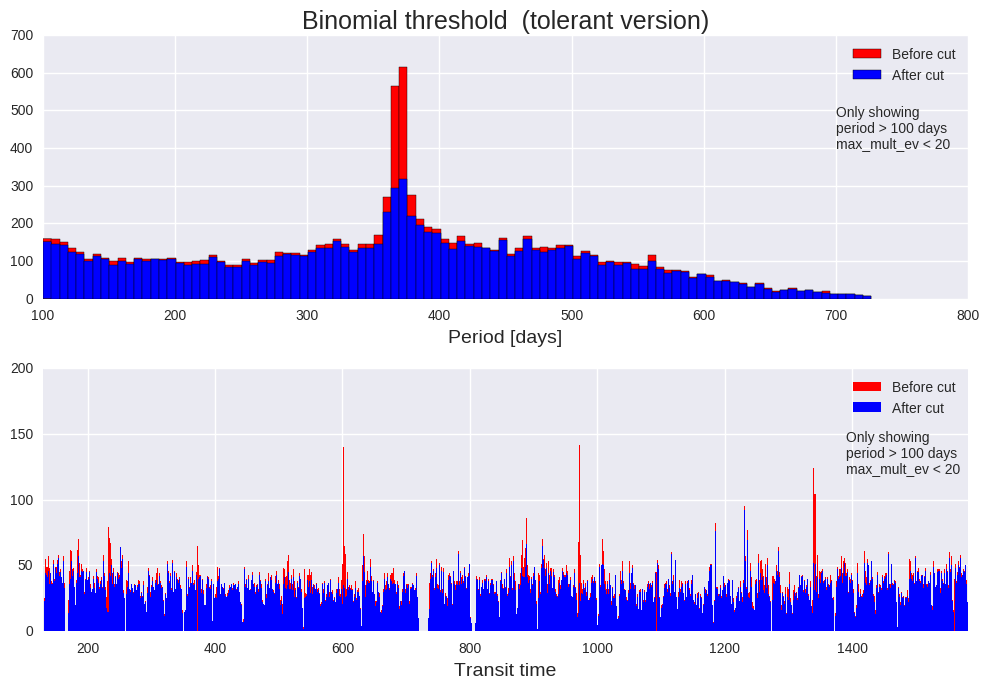

In [961]:
pl.figure(figsize=(10,7))
pl.subplot(211)
_ = pl.hist(transits.groupby('tce').first().tce_period, bins=100, label='Before cut',
            facecolor='red')
_ = pl.hist(transits[~mask_transits_to_remove2].groupby('tce').first().tce_period, bins=100,  label='After cut',
            facecolor='blue')
pl.xlabel('Period [days]', fontsize=14)
pl.legend()
pl.title('Binomial threshold  (tolerant version)', fontsize=18)
pl.text(700, 400, 'Only showing\nperiod > 100 days\nmax_mult_ev < 20', ha='left')

pl.subplot(212)
_ = pl.hist(transits.transit_time_x,
            lw=0, facecolor='red', label='Before cut',
            bins=(KEPLER_END_BK - KEPLER_BEGIN_BK),
            range=(KEPLER_BEGIN_BK, KEPLER_END_BK))
_ = pl.hist(transits[~mask_transits_to_remove2].transit_time_x,
            lw=0, facecolor='blue', label='After cut',
            bins=(KEPLER_END_BK - KEPLER_BEGIN_BK),
            range=(KEPLER_BEGIN_BK, KEPLER_END_BK))
pl.ylim([0, 200])
pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
pl.legend()
pl.xlabel('Transit time', fontsize=14)
pl.text(1390, 120, 'Only showing\nperiod > 100 days\nmax_mult_ev < 20', ha='left')
pl.tight_layout()
pl.savefig('twoday-binomial-threshold-tolerant.png')

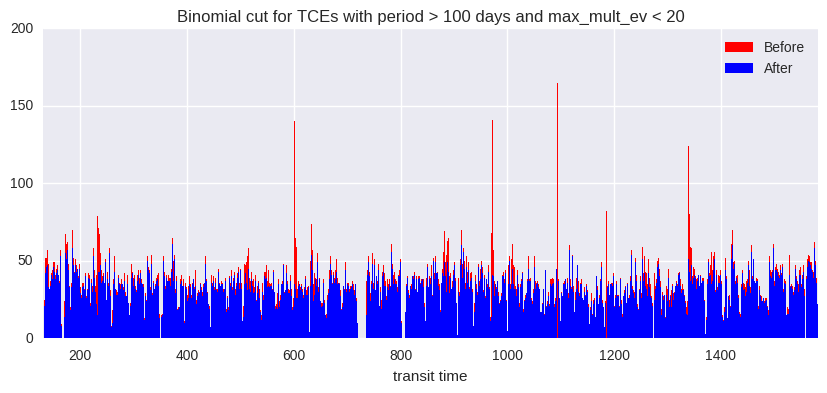

In [495]:
pl.figure(figsize=(10,4))
_ = pl.hist(transits.transit_time_x,
            lw=0, facecolor='red', label='Before',
            bins=(KEPLER_END_BK - KEPLER_BEGIN_BK),
            range=(KEPLER_BEGIN_BK, KEPLER_END_BK))
_ = pl.hist(transits[~mask_transits_to_remove2].transit_time_x,
            lw=0, facecolor='blue', label='After',
            bins=(KEPLER_END_BK - KEPLER_BEGIN_BK),
            range=(KEPLER_BEGIN_BK, KEPLER_END_BK))
pl.ylim([0, 200])
pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
pl.legend()
pl.xlabel('transit time')
pl.title('Binomial cut for TCEs with period > 100 days and max_mult_ev < 20')

(0, 200)

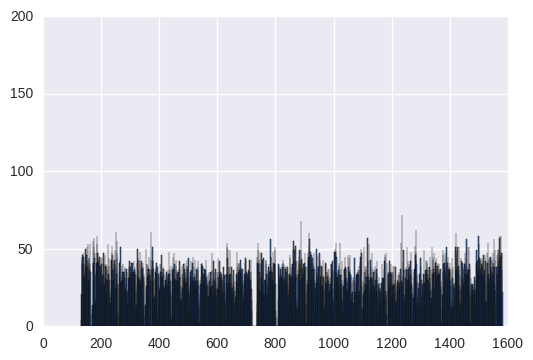

In [473]:
_ = pl.hist(transits[~mask_transits_to_remove2].transit_time_x,
            bins=(KEPLER_END_BK - KEPLER_BEGIN_BK),
            range=(KEPLER_BEGIN_BK, KEPLER_END_BK))
pl.ylim([0, 200])

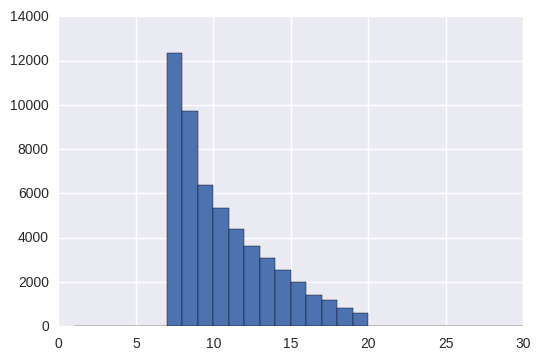

In [325]:
transits.tce_max_mult_ev.hist(bins=30, range=(0,30))

In [326]:
transits[mask_transits_to_remove].groupby('channel').size()

channel
1        3
2       30
3       42
5        1
6        2
7        5
8        1
9        5
10      20
11      15
12      34
13       8
14      24
15       5
16      23
17       4
18     153
19       7
20       4
21       4
22      83
23       7
25      18
26    1571
27      10
28       4
29       6
30      60
31      43
33       3
      ... 
52      54
53       3
54      62
55      48
57       4
58     670
59       7
60       4
61       3
62      55
63      15
65      12
66     173
67      13
68       6
69       6
70      39
71      27
72      34
73      11
74      22
75      12
76      28
77       4
78      23
79      28
80      28
81       2
82      66
83      38
dtype: int64

In [327]:
transits_to_remove = transits[mask_bad_transits]

In [329]:
transits_to_remove[transits_to_remove.channel == 26].transit_day.sort_values().unique().size

50

In [330]:
df = transit_rate[(transit_rate.transit_rate_observed > transit_rate.transit_rate_threshold) & (transit_rate.channel == 58)]
df.shape

(24, 4)

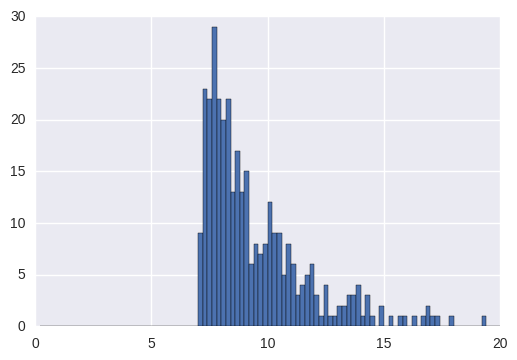

In [331]:
transits_to_remove[transits_to_remove.channel == 44].groupby('tce').first().tce_max_mult_ev.hist(bins=100, range=(0,20))

(0, 30)

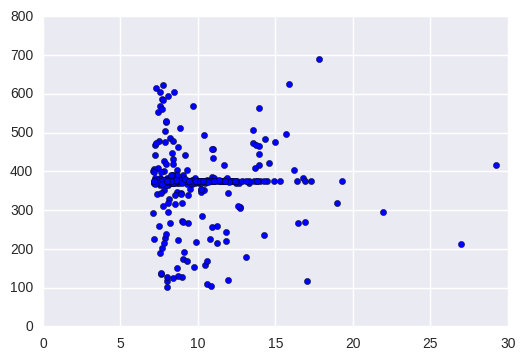

In [295]:
toplot = transits_to_remove[transits_to_remove.channel == 44].groupby('tce').first()
pl.scatter(toplot.tce_max_mult_ev, toplot.tce_period)
pl.xlim([0,30])

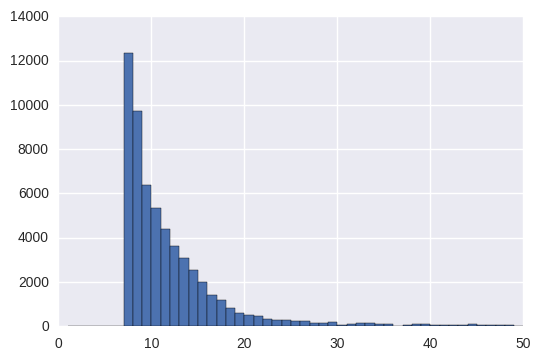

In [297]:
transits.tce_max_mult_ev.hist(bins=50, range=(0,50))